In [1]:
import os
import random

import openai
import tiktoken

from pathlib import Path
from getpass import getpass

from rich.markdown import Markdown
import pandas as pd
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential, # for exponential backoff
)  
import wandb
from wandb.integration.openai import autolog
from langchain_community.document_loaders import PyPDFLoader
from langchain.docstore.document import Document

import matplotlib.pyplot as plt


You will need an OpenAI API key to run this notebook. You can get one [here](https://platform.openai.com/account/api-keys).

In [2]:
if os.getenv("OPENAI_API_KEY") is None:
  if any(['VSCODE' in x for x in os.environ.keys()]):
    print('Please enter password in the VS Code prompt at the top of your VS Code window!')
  os.environ["OPENAI_API_KEY"] = getpass("Paste your OpenAI key from: https://platform.openai.com/account/api-keys\n")
  openai.api_key = os.getenv("OPENAI_API_KEY", "")

assert os.getenv("OPENAI_API_KEY", "").startswith("sk-"), "This doesn't look like a valid OpenAI API key"
print("OpenAI API key configured")

Please enter password in the VS Code prompt at the top of your VS Code window!
OpenAI API key configured


Let's enable W&B autologging to track our experiments.

In [10]:
# start logging to W&B
autolog({"project":"amae", "job_type": "generation", "entity": "chamera"})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chamera. Use `wandb login --relogin` to force relogin


We will add a retry behavior in case we hit the API rate limit

In [3]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    return openai.ChatCompletion.create(**kwargs)

In [11]:
# MODEL_NAME = "gpt-3.5-turbo"
# MODEL_NAME = "gpt-4" # "gpt-4-0613" as of 2024-01-16
MODEL_NAME = "gpt-4-1106-preview" # the updated version from DevDay

In [7]:
messages=[
            {"role": "system", "content": "You're an AI assistant"},
            {"role": "user", "content": "What is your knowledge cutoff?"},
        ]
print("Calling OpenAI API...")
example_response = completion_with_backoff(
    model=MODEL_NAME,
    messages=messages,
    n = 1,
    )
print("OpenAI API call completed")
example_response

Calling OpenAI API...
OpenAI API call completed


<OpenAIObject chat.completion id=chatcmpl-8hcoAuqWML8Z8pOCLo8LRKzYpASvI at 0x1adebd98400> JSON: {
  "id": "chatcmpl-8hcoAuqWML8Z8pOCLo8LRKzYpASvI",
  "object": "chat.completion",
  "created": 1705407974,
  "model": "gpt-4-1106-preview",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "My knowledge cutoff is in 2023, which means I have access to information and events up until that year. If you have questions about recent events or developments beyond that point, I may not have those details. If you need assistance with any topic up until then, feel free to ask."
      },
      "logprobs": null,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 22,
    "completion_tokens": 59,
    "total_tokens": 81
  },
  "system_fingerprint": "fp_168383a679"
}

In [12]:
# read system_template.txt file into an f-string
with open("system_template.txt", "r") as file:
    system_prompt = file.read()

In [13]:
# read prompt_template.txt file into an f-string
with open("prompt_template.txt", "r") as file:
    prompt_template = file.read()

In [16]:
def load_documents(data_dir):
    pdf_files = list(map(str, Path(data_dir).glob("*.pdf")))
    documents = []
    for file_path in pdf_files:
        try:
            documents.extend(PyPDFLoader(file_path=file_path, extract_images=True).load())
        except Exception as e:
            print(f"Failed to load {file_path} due to {e}")
    return documents

In [17]:
documents = load_documents("docs")

Failed to load docs\2911529a-b08d-4367-8e0d-f8c3d2514e81-471547d9-e1b5-4383-a7e8-ea237642db5c.pdf due to cannot reshape array of size 1298 into shape (118,81,newaxis)


In [19]:
len(documents)

1107

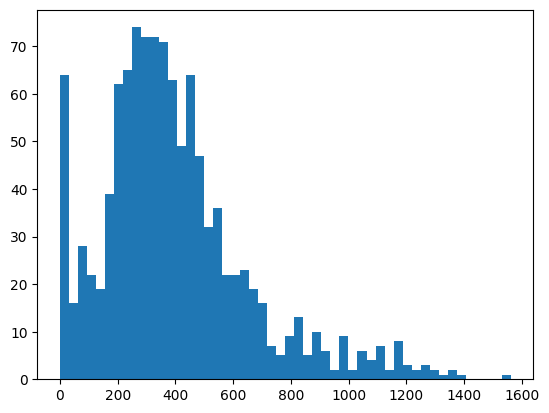

In [20]:
tokenizer = tiktoken.encoding_for_model(MODEL_NAME)
tokens_per_document = [len(tokenizer.encode(document.page_content)) for document in documents]

# generate a histogram of tokens per document
plt.hist(tokens_per_document, bins=50)
plt.show()

In [26]:
# extract a random chunk from a document
def extract_random_chunk(document, max_tokens=1024):
    if isinstance(document, Document):
        tokens = tokenizer.encode(document.page_content)
        if len(tokens) <= max_tokens:
            return document.page_content
    else:
        tokens = tokenizer.encode(document)
        if len(tokens) <= max_tokens:
            return document
    start = random.randint(0, len(tokens) - max_tokens)
    end = start + max_tokens
    return tokenizer.decode(tokens[start:end])

chunk = extract_random_chunk(documents[300])
chunk

'Your vehicle is equipped with many\nfeatures that work together toprotect you and your passengersduring a crash.\nSome features do not require any\naction on your part. These include astrong steel framework that forms asafety cage around the passengercompartment; front and rear crushzones; a collapsible steering column;and tensioners that tighten the frontseat belts in a crash.\nHowever, you and your passengers\ncan’t take full advantage of thesefeatures unless you remain sitting ina proper position and\n. In fact, some safety\nfeatures can contribute to injuries ifthey are not used properly.\nThe following pages explain how you\nc a nt a k ea na c t i v er o l ei np r o t e c t i n gyourself and your passengers.Your Vehicle’s Safety Features\nalways wear\nyour seat beltsDriver and Passenger Safety\n7(1)\n(2)\n(2)(3) (4)\n(5)(7)(8)\n(7)(10)\n(11)(9)\n(6)(9)(6)\n(1) Safety Cage\n(2) Crush Zones(3) Seats and Seat-Backs(4) Head Restraints(5) Collapsible Steering Column\n(6) Seat Belts(7)

In [27]:
delimiter = "\nNew question:\n" # tab separated queries
with open("question_examples.txt", "r", encoding="utf-8") as file:
    data = file.read()
    real_queries = data.split(delimiter)

print(real_queries)
print(len(real_queries))

['How to change an oil in my Honda Accord 2005?', "How to change a flat tire in my car? It's Honda Accord from 2005.", 'I have a Honda Accord from 2005. How can I turn the headlights on?', "Why is my 2005 Accord's fuel economy decreasing?", 'Can I use E85 ethanol fuel in my 2005 Honda Accord?', 'How do I replace the water pump in a 2005 Honda Accord?', 'What could cause the ABS light to stay on in my 2005 Accord?', 'How do I adjust the headlights on my 2005 Accord?', 'What is the proper tire pressure for a 2005 Honda Accord?', 'How do I program a new key fob for my 2005 Honda Accord?', 'What are the signs of a failing oxygen sensor in a 2005 Accord?', 'How do I fix a radiator leak in a 2005 Honda Accord?', 'What does the flashing "D" light on the dashboard of my 2005 Accord mean?', "Why won't my 2005 Accord start even with a new battery?", 'How do I replace the cabin air filter in my 2005 Honda Accord?', 'Can I improve the suspension on my 2005 Accord for a smoother ride?', 'How do I r

In [33]:
def generate_context_prompt(chunk, n_questions=3):
    questions = '\n'.join(random.sample(real_queries, n_questions))
    user_prompt = prompt_template.format(QUESTIONS=questions, CHUNK=chunk)
    return user_prompt

user_prompt = generate_context_prompt(chunk)
Markdown(user_prompt)

Here are some examples of real user questions, you will be judged by how well you match this distribution.         

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
How should I properly load the washing machine to prevent imbalance? How do I adjust or remove the shelves for     
cleaning or storage optimization in regards to my refrigerator? Why is my 2005 Honda Accord's steering wheel       
shaking?                                                                                                           

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
In the next step, you will read a fragment of a home appliance or Honda Accord 2005 car manual documentation. This 
will serve as inspiration for synthetic user question and the source of the answer. Here is the document fragment: 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Your vehicle is equipped with many features that work together toprotect you and your passengersduring a crash.    
Some features do not require any action on your part. These include astrong steel framework that forms asafety cage
around the passengercompartment; front and rear crushzones; a collapsible steering column;and tensioners that      
tighten the frontseat belts in a crash. However, you and your passengers can’t take full advantage of thesefeatures
unless you remain sitting ina proper position and . In fact, some safety features can contribute to injuries ifthey
are not used properly. The following pages explain how you c a nt a k ea na c t i v er o l ei np r o t e c t i n   
gyourself and your passengers.Your Vehicle’s Safety Features always wear your seat beltsDriver and Passenger Safety
7(1) (2) (2)(3) (4) (5)(7)(8) (7)(10) (11)(9) (6)(9)(6) (1) Safety Cage (2) Crush Zones(3) Seats and Seat-Backs(4) 
Head Restraints(5) Collapsible Steering Column (6) Seat Belts(7) Front Airbags(8) Side Airbags(9) Side Curtain     
Airbags(10) Door Locks(11) Front Seat Belt Tensionerš̐ʗ̌̔ʗ̌̑ɹ̍̌ɿ̏̑ɿ̌̎ɹ̨̙̥̏̍̒̎̌ɹ̌̌̍̌ɹ                                                      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
You will now generate a user question and corresponding answer based on the above document. First, explain the user
context and what problems they might be trying to solve. Second, generate user question. Third, provide the        
accurate and concise answer to the user question using the documentation. You'll be evaluated on:                  

 • how realistic is that this question will come from a real user one day?                                         
 • is this question about a car or a home appliance?                                                               
 • can the question be answered using the document fragment above?                                                 
 • how accurate is the answer? Remember that users have different styles and can be imprecise. You are very good at
   impersonating them! Use the following format: CONTEXT: QUESTION: ANSWER: Let's start!

In [34]:
# for each document, generate n (n_generations parameter) questions and corresponding answers
# the answers will be treated as ideal answers for the generated questions 
def generate_questions_and_answers(documents, n_questions=3, n_generations=5):
    questions = []
    for document in documents:
        chunk = extract_random_chunk(document)
        user_prompt = generate_context_prompt(chunk, n_questions)
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
        print("Calling OpenAI API...")
        response = completion_with_backoff(
            model=MODEL_NAME,
            messages=messages,
            n = n_generations,
            )
        print("OpenAI API call completed")
        questions.extend([response.choices[i].message.content for i in range(n_generations)])
    return questions

In [35]:
# function to parse model generation and extract CONTEXT, QUESTION and ANSWER
def parse_generation(generation):
    lines = generation.split("\n")
    context = []
    question = []
    answer = []
    flag = None
    
    for line in lines:
        if "CONTEXT:" in line:
            flag = "context"
            line = line.replace("CONTEXT:", "").strip()
        elif "QUESTION:" in line:
            flag = "question"
            line = line.replace("QUESTION:", "").strip()
        elif "ANSWER:" in line:
            flag = "answer"
            line = line.replace("ANSWER:", "").strip()

        if flag == "context":
            context.append(line)
        elif flag == "question":
            question.append(line)
        elif flag == "answer":
            answer.append(line)

    context = "\n".join(context)
    question = "\n".join(question)
    answer = "\n".join(answer)
    return context, question, answer

In [22]:
generations = generate_questions_and_answers([documents[100]], n_questions=3, n_generations=5)
for generation in generations:
    print("New generation:")
    print(parse_generation(generation))
    print("\n")

Calling OpenAI API...
OpenAI API call completed
New generation:
("The user is on a road trip, and plans to charge his phone and a camping light through his car's accessory power sockets. However, he also wants to use his car lighter. He's unsure of the power limitations, and whether all devices can operate simultaneously.\n", 'Can I use my phone charger in the car socket while using the light? Also, can I use the lighter at the same time?\n', 'Yes, you can use your phone charger and camping light at the same time, as long as their combined power rating does not exceed 120 watts, or 10 amps. However, the sockets in your car cannot power an automotive type cigarette lighter. Always remember to switch the ignition on to either ACCESSORY (I) or ON (II) to use the power sockets.\n')


New generation:
("The user recently purchased a used 2005 Honda Accord. He notices that the vehicle has accessory power sockets, but he is unsure about their use and the amount of power they could supply. He i

In [39]:
def get_best_documents(documents):
    # filter out documents that are likely to be tables or pages with images
    non_relevant_documents = [document for document in documents if document.page_content.count('.') < 200]
    # get the top 3% of documents by tokens count
    top_documents = sorted(non_relevant_documents, key=lambda x: len(tokenizer.encode(x.page_content)),
                           reverse=True)[:int(0.03 * len(non_relevant_documents))]
    return top_documents

len(get_best_documents(documents))

32

In [41]:
parsed_generations = []
generations = generate_questions_and_answers(get_best_documents(documents), n_questions=3, n_generations=5)
for generation in generations:
    context, question, answer = parse_generation(generation)
    parsed_generations.append({"context": context, "question": question, "answer": answer})

# let's convert parsed_generations to a pandas dataframe and save it locally
df = pd.DataFrame(parsed_generations)
df.to_csv('generated_examples.csv', index=False)

# log df as a table to W&B for interactive exploration
wandb.log({"generated_examples": wandb.Table(dataframe=df)})

wandb.log({"openai_gen_model": example_response.model})

# log csv file as an artifact to W&B for later use
artifact = wandb.Artifact("generated_examples", type="dataset")
artifact.add_file("generated_examples.csv")
wandb.log_artifact(artifact)

Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call completed
Calling OpenAI API...
OpenAI API call co

<Artifact generated_examples>

In [42]:
wandb.finish()

usage/completion_tokens,▁▃▄▄▃▄▃▂▇▆▂▄▃▄█▄▃▁▄▂▄▃▃▆▃▁▂▅▄▅▄▄
usage/elapsed_time,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
usage/prompt_tokens,▄▆▄▅▃▇▄▄▄▁▄▄▃▄▄▅▄▁▅▄▄▇▂▅█▅▃█▃▇▆▄
usage/total_tokens,▁▃▄▄▃▄▃▂▇▅▂▄▃▄█▄▃▁▄▂▄▃▃▆▃▁▂▅▄▅▄▄
openai_gen_model,gpt-4-1106-preview
usage/completion_tokens,1184
usage/elapsed_time,0.0
usage/prompt_tokens,1398
usage/total_tokens,2582


### Round1:

Input:
- pages of Honda Accord manual
- each page had to be a non-content table page
- top 5% pages with the most tokens available
- resulted in 14 pages
- 3 questions per page
- 5 generations per page
- gpt-4-0613 model

Output:
- API calls cost: 1.34$

### Round 2:

Input:
- pages of Honda Accord, washing machine, dishwasher, oven, refrigerator, induction hob manuals
- each page had to be a non-content table page
- top 3% pages with the most tokens available
- resulted in 32 pages
- 3 questions per page
- 5 generations per page
- gpt-4-1106-preview model

Output:
- API calls cost: 0.95$
